In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths
from calls import plot_call_features, compute_features, call_extraction

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src/bout', '../src/bout', '../src/bout', '../src/bout', '../src', '../src', '../src/activity', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/calls', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
FREQUENCY_COLOR_MAPPINGS = {
                    'LF' : 'cyan',
                    'HF' : 'orange'
                        }

LABEL_FOR_GROUPS = {
                    0: 'LF', 
                    1: 'HF'
                    }

FIGSIZE = (12, 6)

DURATION = 300

In [5]:
PADDED_CALL_LENGTH = 0.06

def open_and_get_call_info(audio_file, dets):
    welch_key = 'all_locations'
    output_dir = Path(f'../data/generated_welch/{welch_key}')
    output_file_type = 'top1_inbouts_welch_signals'
    welch_data = pd.read_csv(output_dir / f'2022_{welch_key}_{output_file_type}.csv', index_col=0, low_memory=False)
    k = 2
    kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=1).fit(welch_data.values)

    features_of_interest = gather_features_of_interest(dets, kmean_welch, audio_file)

    dets.reset_index(drop=True, inplace=True)
    dets['index'] = dets.index
    dets['file_name'] = pd.DatetimeIndex(pd.to_datetime(dets['input_file'], format='%Y%m%d_%H%M%S', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')
    dets['sampling_rate'] = len(dets) * [audio_file.samplerate]
    dets.insert(0, 'SNR', features_of_interest['snrs'])
    dets.insert(0, 'peak_frequency', features_of_interest['peak_freqs'])
    dets.insert(0, 'KMEANS_CLASSES', pd.Series(features_of_interest['classes']).map(LABEL_FOR_GROUPS))

    return features_of_interest['call_signals'], dets

def gather_features_of_interest(dets, kmean_welch, audio_file):
    fs = audio_file.samplerate
    features_of_interest = dict()
    features_of_interest['call_signals'] = []
    features_of_interest['welch_signals'] = []
    features_of_interest['snrs'] = []
    features_of_interest['peak_freqs'] = []
    features_of_interest['classes'] = []
    nyquist = fs//2
    for index, row in dets.iterrows():
        audio_seg, length_of_section = get_section_of_call_in_file(row, audio_file)
        
        freq_pad = 2000
        low_freq_cutoff = row['low_freq']-freq_pad
        high_freq_cutoff = min(nyquist-1, row['high_freq']+freq_pad)
        band_limited_audio_seg = call_extraction.bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        signal = band_limited_audio_seg.copy()
        signal[:int(fs*(length_of_section))] = 0
        noise = band_limited_audio_seg - signal
        snr_call_signal = signal[-int(fs*length_of_section):]
        snr_noise_signal = noise[:int(fs*length_of_section)]
        features_of_interest['call_signals'].append(snr_call_signal)

        snr = call_extraction.get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
        features_of_interest['snrs'].append(snr)

        welch_info = dict()
        welch_info['num_points'] = 100
        max_visible_frequency = 96000
        welch_info['max_freq_visible'] = max_visible_frequency
        welch_signal = compute_features.compute_welch_psd_of_call(snr_call_signal, fs, welch_info)
        features_of_interest['welch_signals'].append(welch_signal)

        peaks = np.where(welch_signal==max(welch_signal))[0][0]
        features_of_interest['peak_freqs'].append((max_visible_frequency/len(welch_signal))*peaks)
        
        welch_signal = (welch_signal).reshape(1, len(welch_signal))
        features_of_interest['classes'].append(kmean_welch.predict(welch_signal)[0])

    features_of_interest['call_signals'] = np.array(features_of_interest['call_signals'], dtype='object')

    return features_of_interest

def get_section_of_call_in_file(detection, audio_file):
    fs = audio_file.samplerate
    call_dur = (detection['end_time'] - detection['start_time'])
    pad = 0.004
    start = detection['start_time'] - call_dur - (3*pad)
    duration = (2 * call_dur) + (4*pad)
    end = detection['end_time']
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    length_of_section = call_dur + (2*pad)

    return audio_seg, length_of_section

In [6]:
def plot_colored_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=FIGSIZE)
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['KMEANS_CLASSES']], facecolor='none', alpha=1)
        
        ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 96000/(fs/2), 11), labels=np.linspace(0, 96, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.ylim(0, 96000/(fs/2))
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y')
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_colored_dets_over_audio_seg_w_bounds(audio_features, spec_features, call_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=FIGSIZE)
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['KMEANS_CLASSES']], facecolor='none', alpha=1)
        
        ax.add_patch(rect)

    rect = patches.Rectangle((0,(call_features['median_lf']-7000)/(fs/2)), duration*fs, 14000/(fs/2), 
                             linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS['LF'], facecolor=FREQUENCY_COLOR_MAPPINGS['LF'], alpha=0.4)
    ax.add_patch(rect)
    rect = patches.Rectangle((0,(call_features['median_hf']-7000)/(fs/2)), duration*fs, (fs/2 - (call_features['median_hf']-7000))/(fs/2), 
                             linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS['HF'], facecolor=FREQUENCY_COLOR_MAPPINGS['HF'], alpha=0.4)
    ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 96000/(fs/2), 11), labels=np.linspace(0, 96, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.ylim(0, 96000/(fs/2))
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y')
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_audio_seg(audio_features, spec_features):
    """
    Function to plot the spectrogram of a provided audio segment
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=FIGSIZE)
    plt.rcParams.update({'font.size' : 24})
    plt.title(f"Audio collected from {audio_features['site_name']} on {audio_features['file_datetime']} UTC", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    plt.yticks(ticks=np.linspace(0, 96000/(fs/2), 11), labels=np.linspace(0, 96, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.ylim(0, 96000/(fs/2))
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

def load_and_plot_all_examples_file(file_path, bd2_dets, start, duration, rm_dB=50, nfft=1024):
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) -  rm_dB # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['site_name'] = SITE_NAMES[file_path.parent.name]
    audio_features['file_datetime'] = dt.datetime.strptime(file_path.name, "%Y%m%d_%H%M%S.WAV").strftime('%Y/%m/%d %H:%M')
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = nfft
    spec_features['cmap'] = 'jet'

    site_key = file_path.parent.name

    plot_audio_seg(audio_features, spec_features)
    call_signals, dets = open_and_get_call_info(audio_file, bd2_dets.copy())
    plot_dets = dets.loc[(dets['start_time'] > start)&(dets['end_time'] < (start+duration))]
    plot_colored_dets_over_audio_seg(audio_features, spec_features, plot_dets)

    median_peak_HF_freq = dets[dets['KMEANS_CLASSES']=='HF']['peak_frequency'].median()
    median_peak_LF_freq = dets[dets['KMEANS_CLASSES']=='LF']['peak_frequency'].median()
    print(f'Median LF Frequency in file: {median_peak_LF_freq}')
    print(f'Median HF Frequency in file: {median_peak_HF_freq}')
    lf_inds = (plot_dets['peak_frequency']<median_peak_LF_freq+7000)&(plot_dets['peak_frequency']>median_peak_LF_freq-7000)
    hf_inds = (plot_dets['peak_frequency']>median_peak_HF_freq-7000)

    lf_dets = plot_dets[lf_inds&(plot_dets['KMEANS_CLASSES']=='LF')]
    hf_dets = plot_dets[hf_inds&(plot_dets['KMEANS_CLASSES']=='HF')]

    all_dets = pd.concat([hf_dets, lf_dets]).sort_index()

    call_features = dict()
    call_features['median_lf'] = median_peak_LF_freq
    call_features['median_hf'] = median_peak_HF_freq
    plot_colored_dets_over_audio_seg_w_bounds(audio_features, spec_features, call_features, all_dets)

    return plot_dets, all_dets

Looking at Foliage
Looking at 20210910_030000.WAV


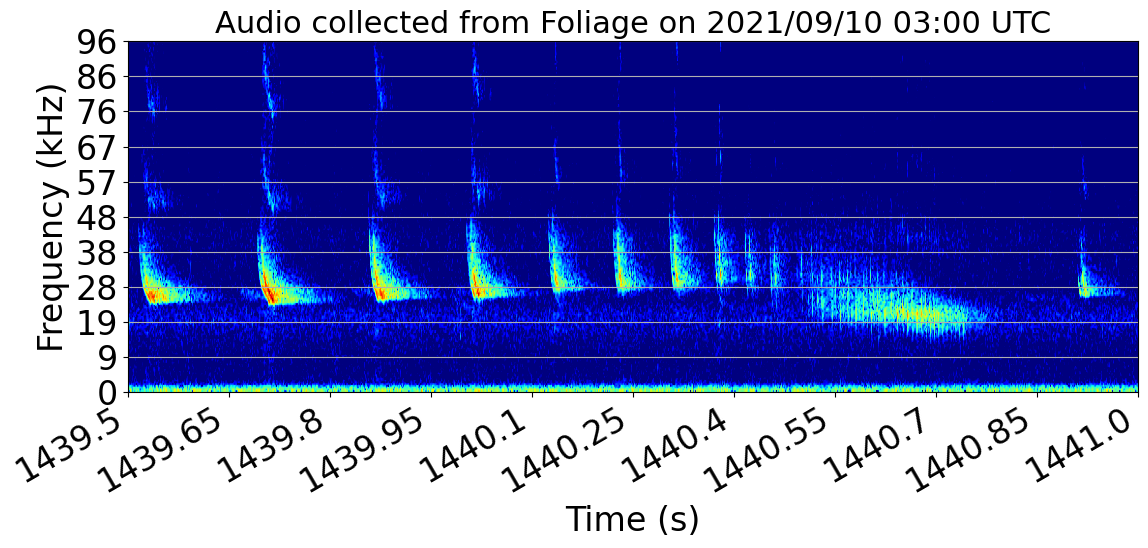

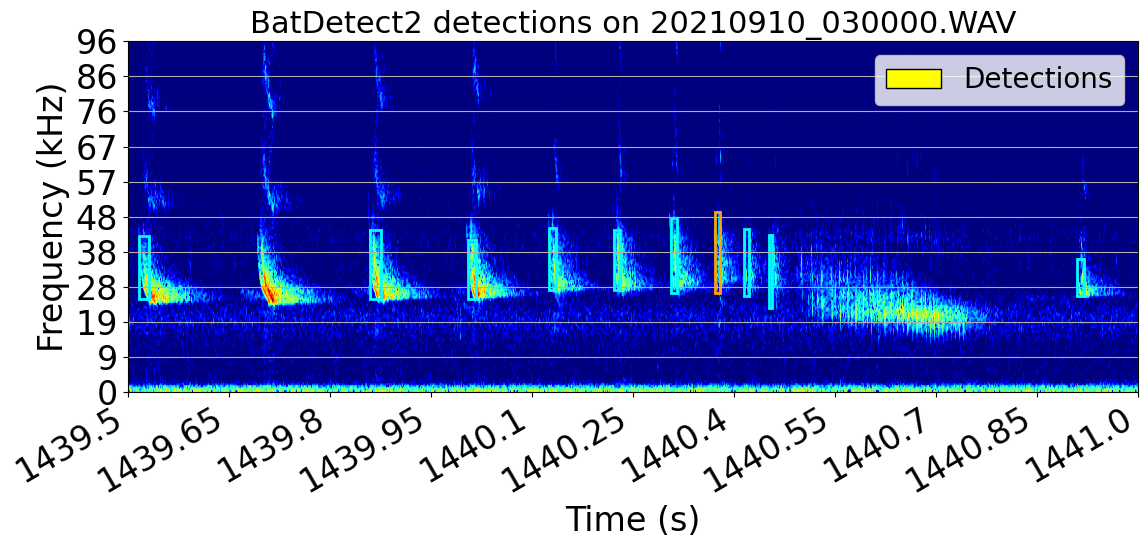

Median LF Frequency in file: 25920.0
Median HF Frequency in file: 42240.0


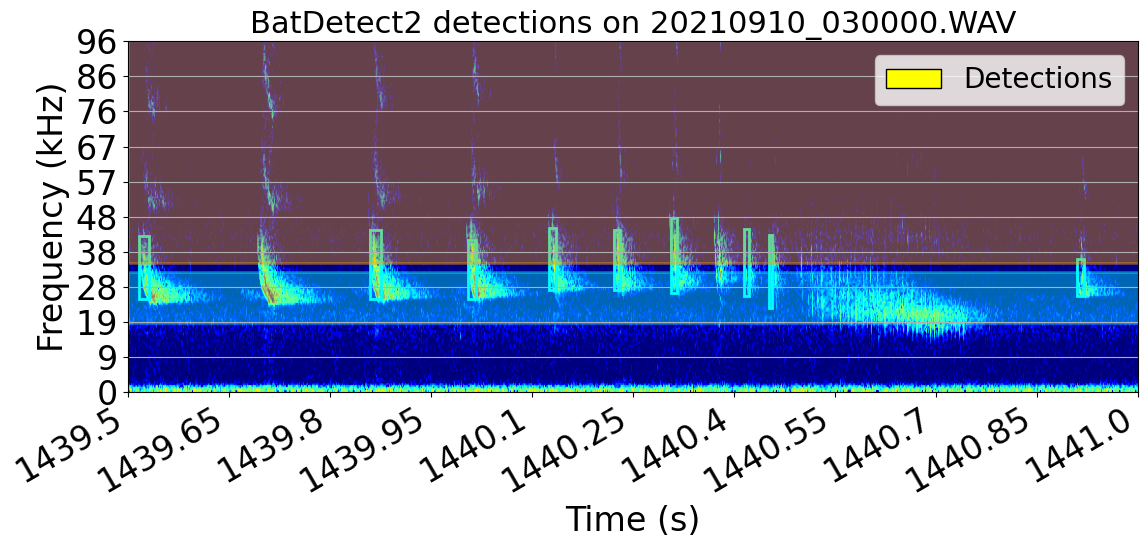

In [7]:
site_key = 'Foliage'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

file_path = files_from_loc[0]
filename = file_path.name
csv_path = Path(f'../batdetect2_outputs/recover-20210912/{site_key}/bd2_{filename.split(".")[0]}.csv')
print(f'Looking at {file_path.name}')
start = 1439.5
duration = 1.5
rm_dB = 45
nfft = 512

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)

mis_dets, fix_dets = load_and_plot_all_examples_file(file_path, batdetect2_predictions_no_dutycycle, start, duration, rm_dB, nfft)

In [8]:
removed_dets = mis_dets.loc[list(set(mis_dets.index) - set(fix_dets.index))]
removed_dets

,KMEANS_CLASSES,peak_frequency,SNR,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,...,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name,index,file_name,sampling_rate
1953,HF,31680.0,23.218547,LF1,2021-09-10 03:24:00.371500,2021-09-10 03:24:00.371500,2021-09-10 03:24:00.379,1440.3715,1440.379,27187.0,...,0.302,0.53,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage,1953,20210910_030000.WAV,250000
